In [1]:
from pathlib import Path
from tqdm import tqdm
import SimpleITK as sitk
import numpy as np
import pandas as pd
import trimesh
import pyvista as pv
import matplotlib.pyplot as plt

from dataloaders import VIA11_Corrected_CS_Loader

from PIL import Image, ImageDraw, ImageFont
from spam import SPAM

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
mesh_paths = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/meshes/n20d24_corr/')

In [4]:
for f in mesh_paths.iterdir():
    if f.is_dir():
        meshes = [x for x in f.glob('**/*.ply')]
        spam_path = f/'imgs/spam'
        spam_path.mkdir(parents=True, exist_ok=True)
        for meshp in tqdm(meshes):
            plotter = pv.Plotter(off_screen=True, line_smoothing=True, polygon_smoothing=True)
            mesh = pv.read(str(meshp))
            actor = plotter.add_mesh(mesh, color='white', smooth_shading=True)
            # https://docs.pyvista.org/version/stable/api/core/camera.html
            plotter.camera_position = 'yz'
            plotter.camera.elevation = -40
            plotter.camera.roll += -10
            plt.imshow(plotter.screenshot(transparent_background=True))
            plt.axis('off')
            plt.savefig(spam_path/(meshp.name).replace('.ply', '.png'), bbox_inches='tight', pad_inches=0, dpi=300,
                        transparent=True)
            plt.close()
            plotter.close()
            # break
            
        # break
        

100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


In [34]:
out_path = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/meshes/n20d24_corr')

for isomap_dir in out_path.iterdir():
    if isomap_dir.is_dir():
        isomap_dir_feat = isomap_dir.name
        
        
        sulci_imgs_path = mesh_paths/f'{isomap_dir_feat}/imgs/spam'
        spam_imgs = [x for x in sulci_imgs_path.glob('**/*.png')]

        x_coords = np.linspace(0, 3000, 20)
        x_coords = x_coords - x_coords[0]+ 10

        resize_scale = 0.5
        padd = 50
        background = Image.new('RGBA', (5000, 2000), (255, 255, 255, 255))
        draw = ImageDraw.Draw(background)
        font = ImageFont.truetype("/mrhome/vladyslavz/Downloads/Lato/Lato-Regular.ttf",
                                48)
        spam_loc = 1200

        for i,s in enumerate(spam_imgs):
            spam_img = Image.open(s, 'r')
            bbox = spam_img.getbbox()
            spam_img = spam_img.crop(bbox)
            spam_img = spam_img.resize((int(spam_img.size[0]*resize_scale),
                                        int(spam_img.size[1]*resize_scale)))
            background.paste(spam_img, (int(x_coords[i]) + padd*i, spam_loc), spam_img)
            
            isomap_val = '{:.2f}'.format(float(s.name.split('_')[1][:-4]))
            spam_img_h, spam_img_w = spam_img.size
            draw.text((x_coords[i]+spam_img_w/2-180 + padd*i,
                    spam_loc + 175+350),
                    str(isomap_val),(0,0,0, 255),
                    font=font)

        background.save(out_path/f'{isomap_dir_feat}_SPAM.png')

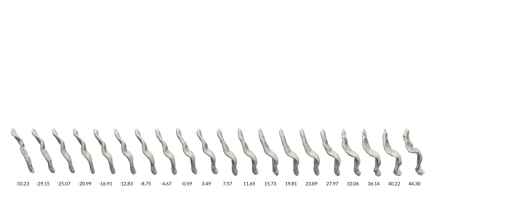

In [35]:
# plot
background_img = plt.imread('out.png')
plt.imshow(background_img)
# plt.axes().set_aspect('equal')
plt.axis('off')
plt.show()

In [9]:
ismap, sdm_transformed = pd.read_pickle('./meshes/n20d24_corr/spam_isomap_meta.pkl')
sulci_reg_keys = np.load('/mrhome/vladyslavz/git/central-sulcus-analysis/sulci_reg_keys_corr.npy')

In [10]:
subj_isomap_df = pd.DataFrame([(x[16:17], x[21:],
                                *sdm_transformed[i]) for i, x in enumerate(sulci_reg_keys[0])],
                              columns=['side', 'subject',
                                       *['isomap_'+str(i) for i in range(24)]])
subj_isomap_df

,side,subject,isomap_0,isomap_1,isomap_2,isomap_3,isomap_4,isomap_5,isomap_6,isomap_7,...,isomap_14,isomap_15,isomap_16,isomap_17,isomap_18,isomap_19,isomap_20,isomap_21,isomap_22,isomap_23
0,l,sub-via003,-28.311126,-8.353465,9.517017,-4.462221,5.806272,-2.979324,-10.910120,9.677116,...,-1.248830,-1.146897,-0.367486,-0.134618,1.307990,3.888450,-2.259402,-2.896462,0.298815,0.284321
1,r,_sub-via003,-7.405592,10.078717,9.660835,-15.843346,-7.962872,-5.179321,0.305661,-3.927376,...,-1.140463,4.963632,-4.097380,0.617560,2.698605,-4.101082,3.348816,1.364171,-0.348255,-2.609681
2,l,sub-via004,-11.083510,10.252689,-13.466419,5.700871,7.573493,-7.711238,-4.697794,-0.308248,...,-0.079783,-3.478574,-0.035031,-1.065782,4.294571,-0.104015,-1.051491,-0.960138,1.550539,-3.567539
3,r,_sub-via004,1.726812,5.962510,-18.094953,1.565194,-1.625788,-6.249134,0.417450,4.924398,...,-4.226386,-1.687876,0.574779,-0.366671,7.067124,-5.882466,1.801701,4.977742,0.804781,-2.246432
4,l,sub-via005,19.721528,11.746059,1.828329,-7.371172,-3.768967,-1.464389,5.367816,1.712913,...,-3.036300,-0.875732,-0.892088,4.003014,-1.640301,3.406384,1.964429,-0.463342,0.883141,-1.283938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,r,_sub-via515,-20.649426,10.782152,18.068736,-9.008073,-0.597874,-1.426741,1.787385,-0.411395,...,0.020018,5.050510,-3.585082,-0.396233,-0.547129,-0.992386,1.357747,-2.859752,0.358542,-3.273375
568,l,sub-via517,-21.622949,-4.610133,-2.051653,7.184667,2.091527,-3.033395,10.028705,5.608876,...,2.013052,3.763374,3.556276,-3.166458,-2.854649,2.594378,2.804656,-2.192297,3.159771,0.464516
569,r,_sub-via517,-3.659729,16.570245,-10.300054,4.089159,-5.483322,-7.738429,-0.410071,-7.170726,...,-6.970609,-5.365843,-1.077620,1.343889,0.119327,7.438383,-4.923218,1.829862,-1.453688,3.269563
570,l,sub-via522,-10.697686,5.173126,-2.641910,0.090183,-11.648489,3.374039,2.774796,-1.206396,...,-3.679418,1.820867,1.908986,-0.219649,-1.424397,0.626238,1.655242,0.758384,0.468372,1.444789


In [11]:
asmp = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/meshes/all_subj_meshes_reg')

In [12]:
via11_scQA = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/QA_centralSulcus_lkj.xlsx')[['subjects', 'sites', 'vis_QA', 'editted']]
via11_scQA = via11_scQA[~via11_scQA.subjects.isna()]
via11_scQA = via11_scQA.set_index('subjects')

via11_demo = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/VIA11_fmriflanker_info_database_2021jan25.xlsx')
via11_demo = via11_demo[via11_demo.mp2rage_exists == 1].drop(columns=['in_via11', 'stormdb'])
via11_demo['subjects'] = [f'sub-via{x:03d}' for x in via11_demo.via_id]
via11_demo = via11_demo[~via11_demo.subjects.isna()]
via11_demo = via11_demo[via11_demo.subjects.isin(via11_scQA.index.values)]
via11_demo = via11_demo.set_index('subjects')

for subject in via11_demo.index.values:
    # via11_demo.loc[subject, 'site'] = via11_scQA.loc[subject, 'sites']
    via11_demo.loc[subject, 'vis_QA'] = via11_scQA.loc[subject, 'vis_QA']
    via11_demo.loc[subject, 'editted'] = via11_scQA.loc[subject, 'editted']
    
via11_demo

,via_id,site,group,mri_age,sex,handedness,tanner,cbcl_total,cbcl_external,cbcl_internal,...,flanker_behav_deltaRT_3sd,no_sMRI,no_flanker_fMRI,Braces,neurological disorder,in_flanker_behav,in_flanker_analysis,comment,vis_QA,editted
subjects,,,,,,,,,,,,,,,,,,,,,
sub-via003,3,1.0,3.0,12.188912,0.0,3.0,2.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0
sub-via004,4,1.0,3.0,11.764545,0.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,wrong e-prime,1.0,0.0
sub-via005,5,1.0,3.0,11.493498,0.0,3.0,2.0,9.0,2.0,3.0,...,0.0,0.0,0.0,0,0,0.0,0.0,wrong e-prime,1.0,0.0
sub-via010,10,2.0,2.0,11.718001,1.0,2.0,2.0,62.0,14.0,13.0,...,0.0,0.0,0.0,0,0,0.0,0.0,wrong e-prime,2.0,1.0
sub-via013,13,2.0,3.0,12.287474,0.0,2.0,3.0,7.0,2.0,2.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-via517,517,2.0,3.0,11.641342,1.0,3.0,3.0,4.0,0.0,3.0,...,0.0,1.0,1.0,0,0,0.0,0.0,stim. Com. Malfunction,1.0,0.0
sub-via518,518,1.0,3.0,12.353183,1.0,3.0,2.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0
sub-via519,519,2.0,3.0,12.533881,1.0,3.0,4.0,11.0,2.0,3.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0


In [13]:
good_bv = via11_demo[(via11_demo.vis_QA == 1)].index.values

In [14]:
good_ismoap_df = subj_isomap_df
good_ismoap_df.reset_index(inplace=True)

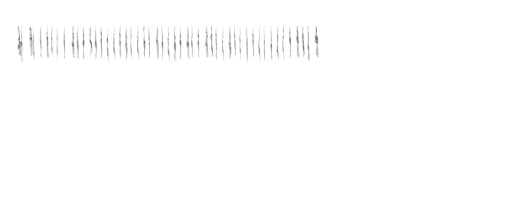

In [20]:
TOTAL_IMGS = 50
isomap_dim = 'isomap_11'
x_coords = np.linspace(0, 3000, TOTAL_IMGS)
x_coords = x_coords - x_coords[0]+ 10

background = Image.new('RGBA', (5000, 2000), (255, 255, 255, 255))
draw = ImageDraw.Draw(background)
font = ImageFont.truetype("/mrhome/vladyslavz/Downloads/Lato/Lato-Regular.ttf",
                          48)
spam_loc = 100

resize_scale = 0.5
padd = 0

sorted_indexes_array = good_ismoap_df.sort_values(by=isomap_dim, ascending=True).index.values
spaced_idxs = np.round(np.linspace(0, len(sorted_indexes_array) - 1, TOTAL_IMGS)).astype(int)

for idx, i in enumerate(spaced_idxs):
    # print(sorted_indexes_array[i])
    subject = good_ismoap_df.iloc[sorted_indexes_array[i]].subject.strip('_')
    side = good_ismoap_df.iloc[sorted_indexes_array[i]].side
    side = 'left' if side == 'l' else 'right'
    img = Image.open(asmp/f'imgs/{subject}_{side}.png')

    bbox = img.getbbox()
    spam_img = img.crop(bbox)
    spam_img = img.resize((int(spam_img.size[0]*resize_scale),
                                int(spam_img.size[1]*resize_scale)))
    background.paste(spam_img, (int(x_coords[idx]) + padd*i, spam_loc), spam_img)
    # break

background.save('out2.png')
# plot
background_img = plt.imread('out2.png')
plt.imshow(background_img)
# plt.axes().set_aspect('equal')
plt.axis('off')
plt.show()

In [19]:
spam_mpath = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/meshes/all_subj_meshes_reg')
spam_mpaths = spam_mpath.glob('*.ply')

for meshpp in tqdm(spam_mpaths, total=572):

    plotter = pv.Plotter(off_screen=True, line_smoothing=True, polygon_smoothing=True)
    
    mesh = pv.read(str(meshpp))
    actor = plotter.add_mesh(mesh, color='white', smooth_shading=True)
    plotter.camera_position = 'yz'
    plotter.camera.elevation = 0
    plotter.camera.roll += -10
    plotter.camera.azimuth = 30
    plt.imshow(plotter.screenshot(transparent_background=True))
    plt.axis('off')
    plt.savefig(spam_mpath/ ('imgs/' + meshpp.name.replace('.ply', '.png')), bbox_inches='tight', pad_inches=0, dpi=300,
                transparent=True)
    plt.close()
    plotter.close()
    
    # break

100%|██████████| 572/572 [04:08<00:00,  2.30it/s]


In [ ]:
se_3d_cross = np.array([[0, 0, 0, 0, 0],

In [131]:
from scipy.ndimage import binary_closing, binary_opening, binary_dilation, binary_erosion, disk

ImportError: cannot import name 'disk' from 'scipy.ndimage' (/mrhome/vladyslavz/.local/lib/python3.10/site-packages/scipy/ndimage/__init__.py)

In [132]:
from skimage.morphology import binary_closing, binary_opening, binary_dilation, binary_erosion, disk

/mrhome/vladyslavz/anaconda3/envs/css/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


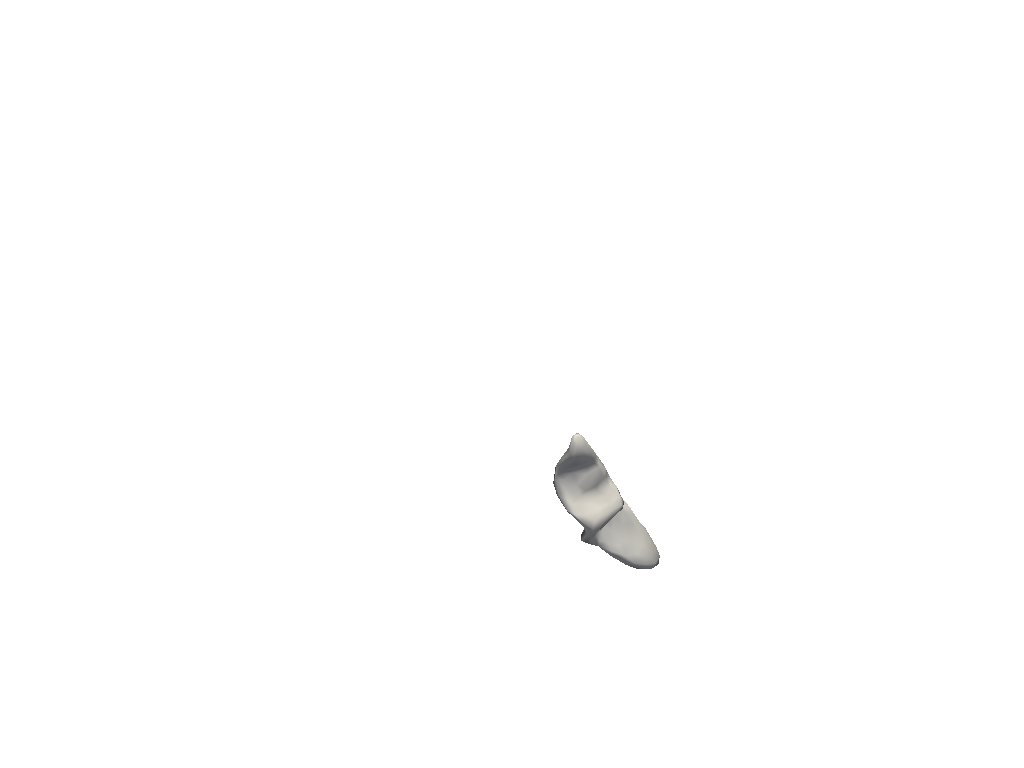

In [107]:
plotter.show()